In [2]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision.utils import save_image
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [3]:
len(os.listdir('../input/celeba-dataset/img_align_celeba/img_align_celeba'))

202599

In [4]:
# Setting parameters
dataroot = "../input/celeba-dataset/img_align_celeba"
workers = 2

batch_size = 128
image_size = 64

# Number of channels
nc = 3
# Latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 30
# Learning rate for optimizers
lr = 0.0001
# Beta1 hyperparam for Adam optimizers
beta1 = 0.3
ngpu = 1

In [5]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.RandomHorizontalFlip(),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

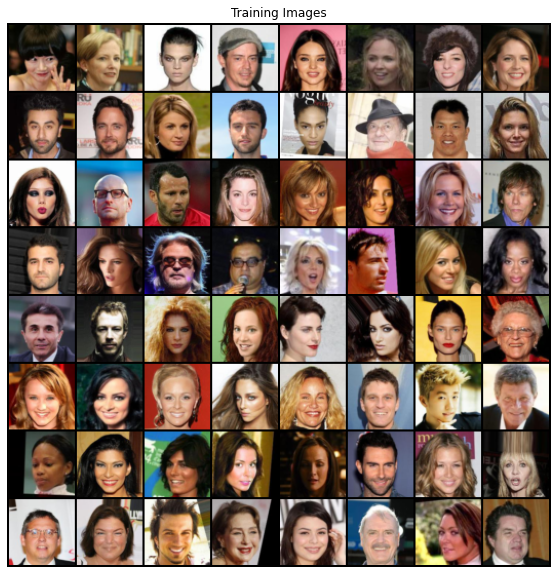

In [6]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images");
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)));

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            """
            nn.ConvTranspose2d(a,b,c,d,e)
            
            a: number of input channel
            b: number of output channel
            c: kernel size
            d: stride
            e: padding
            """
            
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            # (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            # (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            # (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            # ngf x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            
            # nc x 32 x 32
        )

    def forward(self, input):
        return self.main(input)
    
# Create netG
netG = Generator(ngpu).to(device);
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [9]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            """
            nn.Conv2d(a,b,c,d,e)
            
            a: number of input channel
            b: number of output channel
            c: kernel size
            d: stride
            e: padding
            """
            
            # (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
# Create netD
netD = Discriminator(ngpu).to(device);
netD.apply(weights_init);

In [10]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to wisualize the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
scheduler = ReduceLROnPlateau(optimizerD, factor=0.5, patience=2)
scheduler = StepLR(optimizerD, gamma=0.5, step_size=8)

In [11]:
# Training Loop

# Lists to keep track of progress

G_losses = []
D_losses = []
iters = 0

valid_loss_min = np.Inf
patience = 5
# current number of epochs, where validation loss didn't increase
p = 0
# whether training should be stopped
stop = False


print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device, dtype=torch.float)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        iters += 1
    scheduler.step(errD.item())
    
    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
          % (epoch, num_epochs, i, len(dataloader),
             errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
    
#     loss = errG.item()
#     if loss <= valid_loss_min:
#         print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
#         valid_loss_min,
#         loss))
#         torch.save(netD.state_dict(), 'model.pt')
#         valid_loss_min = loss
#         p = 0

#     # check if validation loss didn't improve
#     if loss > valid_loss_min:
#         p += 1
#         print(f'{p} epochs of increasing loss')
#         if p > patience:
#             print('Stopping training')
#             stop = True
#             break        
            
#     if stop:
#         break

Starting Training Loop...
[0/30][1582/1583]	Loss_D: 0.3584	Loss_G: 2.6894	D(x): 0.8240	D(G(z)): 0.1079 / 0.0934


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[1/30][1582/1583]	Loss_D: 0.3359	Loss_G: 3.0713	D(x): 0.9236	D(G(z)): 0.2092 / 0.0608
[2/30][1582/1583]	Loss_D: 0.3999	Loss_G: 2.9445	D(x): 0.9034	D(G(z)): 0.2381 / 0.0654
[3/30][1582/1583]	Loss_D: 0.4583	Loss_G: 3.4569	D(x): 0.9369	D(G(z)): 0.3067 / 0.0408
[4/30][1582/1583]	Loss_D: 0.3824	Loss_G: 3.5553	D(x): 0.9322	D(G(z)): 0.2512 / 0.0369
[5/30][1582/1583]	Loss_D: 0.7515	Loss_G: 0.7607	D(x): 0.5431	D(G(z)): 0.0340 / 0.5198
[6/30][1582/1583]	Loss_D: 0.5082	Loss_G: 4.5013	D(x): 0.9371	D(G(z)): 0.3270 / 0.0144
[7/30][1582/1583]	Loss_D: 0.2862	Loss_G: 3.4955	D(x): 0.9180	D(G(z)): 0.1716 / 0.0370
[8/30][1582/1583]	Loss_D: 0.3636	Loss_G: 1.8716	D(x): 0.7957	D(G(z)): 0.1036 / 0.1827
[9/30][1582/1583]	Loss_D: 0.5955	Loss_G: 1.9606	D(x): 0.6185	D(G(z)): 0.0236 / 0.1874
[10/30][1582/1583]	Loss_D: 0.1596	Loss_G: 3.2206	D(x): 0.9125	D(G(z)): 0.0601 / 0.0502
[11/30][1582/1583]	Loss_D: 0.4763	Loss_G: 1.6813	D(x): 0.6641	D(G(z)): 0.0217 / 0.2365
[12/30][1582/1583]	Loss_D: 0.2340	Loss_G: 2.5712	D(x

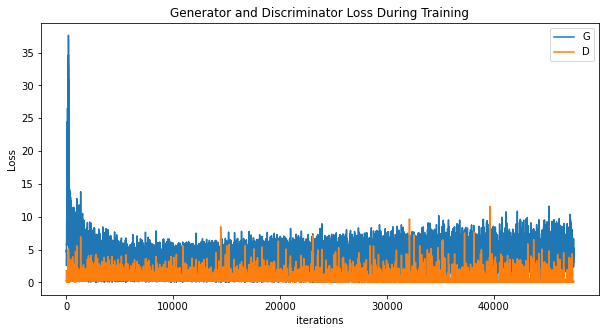

In [12]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [13]:
if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
im_batch_size = 50
n_images=10000
for i_batch in range(0, n_images, im_batch_size):
    gen_z = torch.randn(im_batch_size, nz, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))


import shutil
shutil.make_archive('images', 'zip', '../output_images')

'/kaggle/working/images.zip'

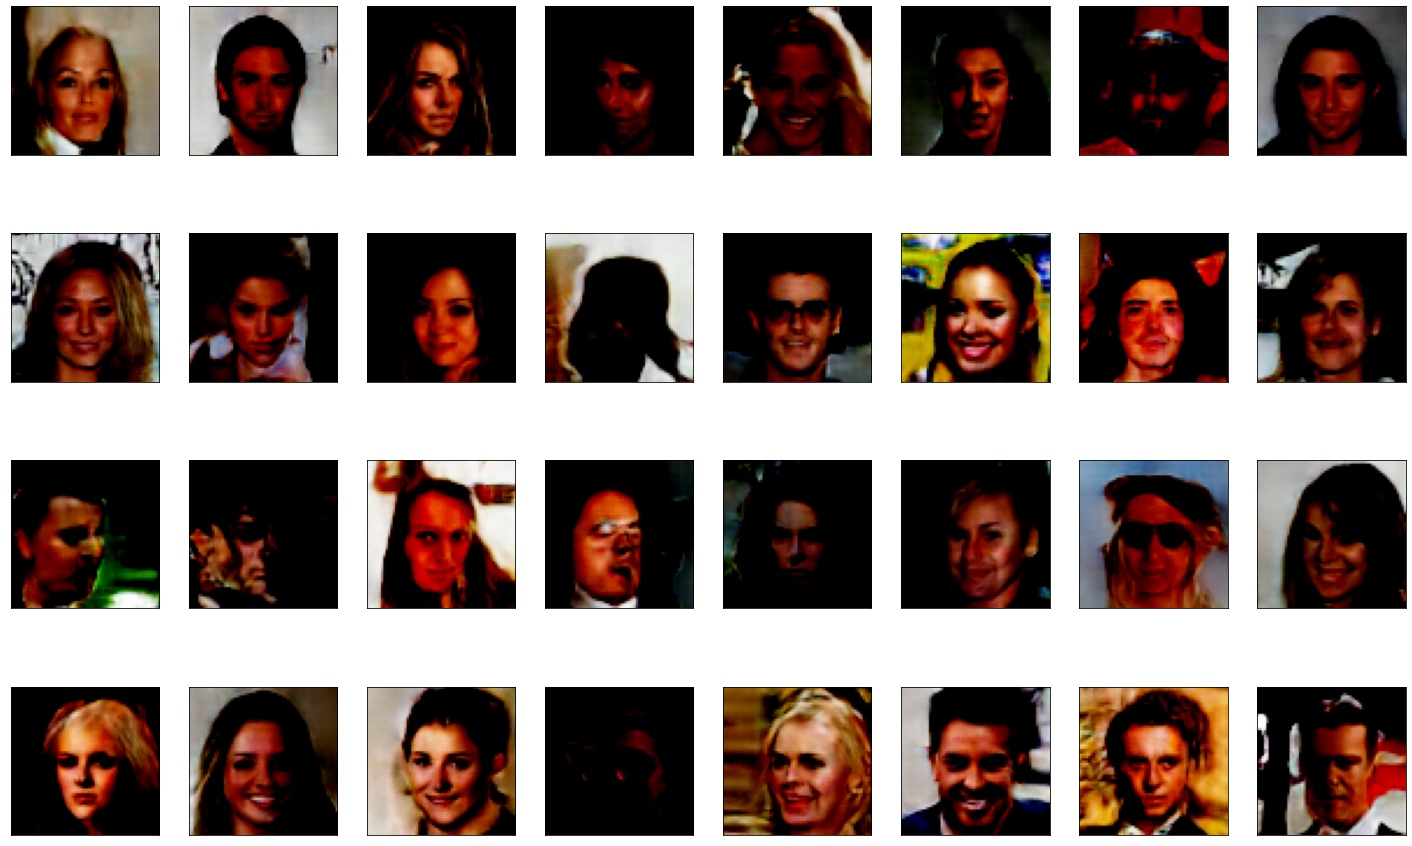

In [14]:
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for i, j in enumerate(images[:32]):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    plt.imshow(j)

In [19]:
print("netD's state_dict:")
for param_tensor in netD.state_dict():
    print(param_tensor, "/t", netD.state_dict()[param_tensor].size())

print("")
print("netG's state_dict:")
for param_tensor in netG.state_dict():
    print(param_tensor, "/t", netG.state_dict()[param_tensor].size())

netD's state_dict:
main.0.weight /t torch.Size([64, 3, 4, 4])
main.2.weight /t torch.Size([128, 64, 4, 4])
main.3.weight /t torch.Size([128])
main.3.bias /t torch.Size([128])
main.3.running_mean /t torch.Size([128])
main.3.running_var /t torch.Size([128])
main.3.num_batches_tracked /t torch.Size([])
main.5.weight /t torch.Size([256, 128, 4, 4])
main.6.weight /t torch.Size([256])
main.6.bias /t torch.Size([256])
main.6.running_mean /t torch.Size([256])
main.6.running_var /t torch.Size([256])
main.6.num_batches_tracked /t torch.Size([])
main.8.weight /t torch.Size([512, 256, 4, 4])
main.9.weight /t torch.Size([512])
main.9.bias /t torch.Size([512])
main.9.running_mean /t torch.Size([512])
main.9.running_var /t torch.Size([512])
main.9.num_batches_tracked /t torch.Size([])
main.11.weight /t torch.Size([1, 512, 4, 4])

netG's state_dict:
main.0.weight /t torch.Size([100, 512, 4, 4])
main.1.weight /t torch.Size([512])
main.1.bias /t torch.Size([512])
main.1.running_mean /t torch.Size([512])

In [30]:
# Save the model
torch.save(netG.state_dict(),'../netG_celeba.pth')
torch.save(netD.state_dict(),'../netD_celeba.pth')

In [28]:
netG2 = Generator(ngpu).to(device)
netG2.load_state_dict = torch.load('../netG_celeba.pth')
netG2.eval()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [29]:
if not os.path.exists('../output_images3'):
    os.mkdir('../output_images3')
im_batch_size = 5
n_images = 10
for i_batch in range(0, n_images, im_batch_size):
    gen_z = torch.randn(im_batch_size, nz, 1, 1, device=device)
    gen_images = netG2(gen_z)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('../output_images3', f'image_{i_batch+i_image:05d}.png'))


import shutil
shutil.make_archive('images3', 'zip', '../output_images3')

'/kaggle/working/images3.zip'